### Unconditional density estmation
Here we will use a [MaskedAutoregressiveFlow](../api/flows.rst#flowjax.flows.MaskedAutoregressiveFlow)
with a [RationalQuadraticSplineTransformer](../api/transformers.rst#flowjax.transformers.RationalQuadraticSplineTransformer)
to approximate the "two-moons" distribution. For a list of available flow architectures, please see [flowjax.flows](../api/flows.rst).

#### Imports and data generation
Importing the required libraries

In [40]:
import jax.numpy as jnp
import jax.random as jr
from flowjax.flows import MaskedAutoregressiveFlow
from flowjax.transformers import RationalQuadraticSplineTransformer
from flowjax.train_utils import train_flow
from flowjax.distributions import Normal
import matplotlib.pyplot as plt
from flowjax.tasks import two_moons

Generating the the toy dataset

In [41]:
n_samples = 10000
rng = jr.PRNGKey(0)
x = two_moons(rng, n_samples)
x = (x - x.mean(axis=0))/x.std(axis=0) # Standardize

#### Creating and training
We now create the flow, using a normal base distribution. We define the spline transformer to have 8 knots, and to be on the interval [-4,4].

In [42]:
key, subkey = jr.split(jr.PRNGKey(0))
base_dist = Normal(jnp.zeros(x.shape[1]))
flow = MaskedAutoregressiveFlow(
    subkey,
    base_dist,
    RationalQuadraticSplineTransformer(K=8, B=4),
)

Training the flow

In [43]:
key, subkey = jr.split(key)
flow, losses = train_flow(subkey, flow, x, learning_rate=1e-3)

 70%|███████   | 35/50 [00:26<00:11,  1.32it/s, train=1.55, val=1.53 (Max patience reached)]


##### Density estimation and sampling
We can use the flow to evaluate the density of arbitrary points

In [47]:
five_points = jnp.ones((5, 2))
flow.log_prob(five_points)

Array([-10.086706, -10.086706, -10.086706, -10.086706, -10.086706],      dtype=float32)

and we can sample the flow

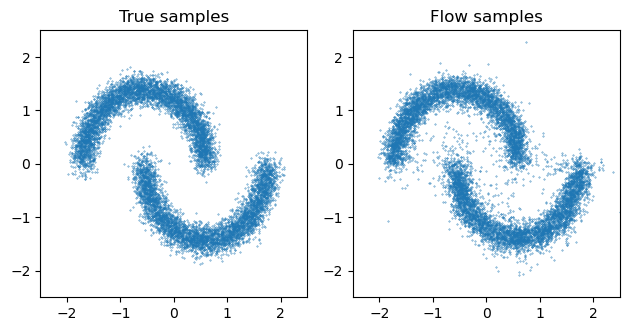

In [48]:
key, subkey = jr.split(key)
x_samples = flow.sample(subkey, n=n_samples)

fig, axs = plt.subplots(ncols=2)

axs[0].scatter(x[:, 0], x[:, 1], s=0.1)
axs[0].set_title("True samples")

axs[1].scatter(x_samples[:, 0], x_samples[:, 1], s=0.1)
axs[1].set_title("Flow samples")

lims = (-2.5, 2.5)
for ax in axs:
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()